In [2]:
import os
os.chdir('..')
os.getcwd()

'C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection'

In [3]:
import torch
import torch.nn as nn
import glob
from dataset import Dataset_SMP, get_preprocessing, get_training_augmentation, split_data
from display import display_result, display_segmentation
import segmentation_models_pytorch as smp
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from models.bisenet import BiSeNet
from metrics import confusion_matrix
import os
import seaborn as sns
import time
from dataset import resize, get_tensor
from PIL import Image
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy

In [4]:
def denormalize(image, preprocessing_fn):
    image_dnrm = image * torch.tensor(preprocessing_fn.keywords['std']).view(-1,1,1) + torch.tensor(preprocessing_fn.keywords['mean']).view(-1,1,1)
    return image_dnrm

def display_eye_segmentation(image, label, score=None, zoom=True):
    fig  = plt.figure(figsize=(20, 15))
    mask = np.ma.masked_where(label == 0, label)
    if zoom:
        x,y = np.where(label.squeeze())
        image = image[min(x)-2:max(x)+2,min(y)-2:max(y)+2]
        mask  = mask[min(x)-2:max(x)+2,min(y)-2:max(y)+2]
    plt.imshow(image, vmin=0, vmax=1)
    plt.imshow(mask, alpha=0.3, cmap='bwr_r')
    #plt.xticks(()),plt.yticks(())
    if score:
        plt.title(score)
    return fig

def display_result(image, label, prediction, score=None, zoom=True, legend=False):
    
    fig = plt.figure(figsize=(20, 5))
    label  = label.squeeze()
    # image
    plt.subplot(121)
    plt.imshow(image)
    plt.title('image')
    plt.xticks(()),plt.yticks(())
    
    # TN - TP - FP - FN
    good_prediction = (label == prediction)
    bad_prediction  = (label != prediction)
    TP = good_prediction & (label == 1.)
    TN = good_prediction & (label == 0.)
    FP = bad_prediction & (label == 0.)    
    FN = bad_prediction & (label == 1.)
    colors = np.array([[0,255,0], [255,0,0], [255,140,0]])/255
    mask_predict = image.copy()
    mask_predict[TP,:] = colors[0] # green
    mask_predict[FP,:] = colors[1] # red
    mask_predict[FN,:] = colors[2] # orange
    label_type = ["TP","FP","FN"]
    legend     = [patches.Patch(color=colors[i], label="{}".format(label_type[i])) for i in range(len(colors))]
    if zoom:
        x,y   = np.where(prediction)
        mask_predict = mask_predict[min(x)-5:max(x)+5,min(y)-5:max(y)+5]   
    plt.subplot(122)
    plt.imshow(mask_predict)
    plt.title('prediction')
    plt.xticks(()),plt.yticks(())
    plt.suptitle(score,fontsize=15)
    #if legend:
    #    plt.legend(handles=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. ) 
    return fig, TP.sum(), FP.sum(), TN.sum(), FN.sum()


# Model

In [5]:
input_size = [1280,704] #(448,448) #[544,960]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
model = smp.Unet(encoder_name="resnet18", encoder_weights='imagenet', activation='sigmoid', classes=1)
model.to(device)
preprocessing_fn = smp.encoders.get_preprocessing_fn("mobilenet_v2", 'imagenet')
preprocessing = get_preprocessing(preprocessing_fn)

# Checkpoint

if model is saved with nn.DataParallel keys don't match there is a "module" key added

In [7]:
path_ckpt = 'C:\\Users\\gueganj\\Desktop\\model_crop\\unet_resnet18_crop_using_landmarks.ckpt'
checkpoint = torch.load(path_ckpt, map_location=device)
if "module" in list(checkpoint['model'].keys())[0]:
    model = nn.DataParallel(model)
model.load_state_dict(checkpoint['model'])
#model = torch.load('C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection\\prediction\\model_frame.ckpt')

print("model loaded")

model loaded


# Data

In [8]:
data_root  = "C:\\Users\\gueganj\\Desktop\\My_DataBase\\nature\\eyes_cropped\\using_landmarks\\"
train_set, valid_set, test_set = split_data(data_root, "images", '.jpg', "masks\\frame", '.png', 200, use_id=True)
valid_image, valid_mask = valid_set
image_name = "045_scanRecord_3"
image_path = valid_image #[os.path.join(data_root,"images",image_name+'.jpg')]
mask_path  = valid_mask #[os.path.join(data_root,"masks\\frame",image_name+'.png')]  glob.glob(data_root+"masks_cropped\\*.png")#

TOTAL : 185  images -  66  personnes
train : 145  images -  52  personnes
valid : 15  images -  6  personnes
test  : 25  images -  8  personnes


In [9]:
input_size = [200,400]
valid_dataset = Dataset_SMP(image_path, mask_path, input_size, None, get_preprocessing(preprocessing_fn))
valid_loader  = torch.utils.data.DataLoader(valid_dataset)

In [10]:
image1, mask1 = iter(valid_loader).next()

# Evaluate

In [11]:
from segmentation_models_pytorch.utils.metrics import IoU

In [12]:
threshold = 0.5
metric    = IoU()
loss      = smp.utils.losses.DiceLoss()

# Get prediction and Display

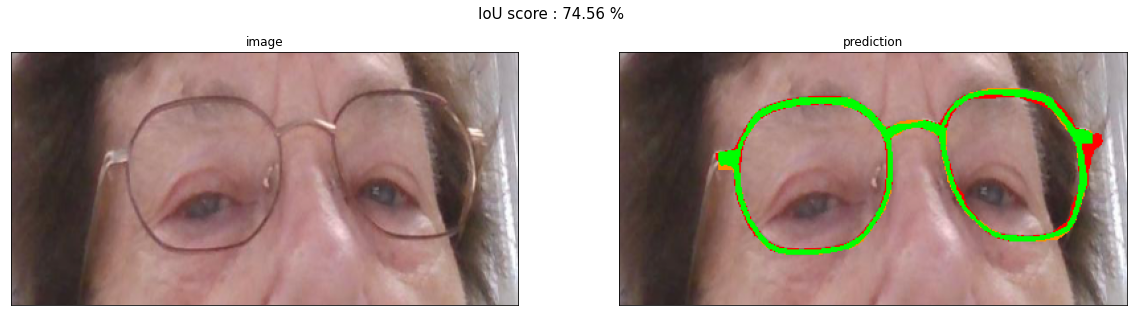

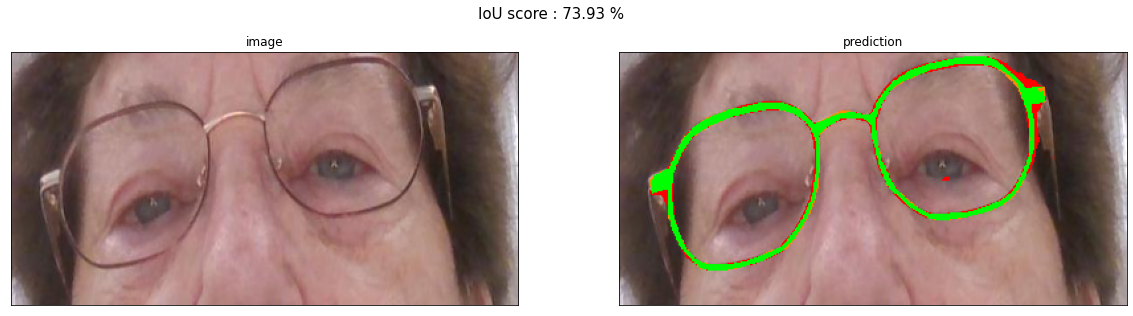

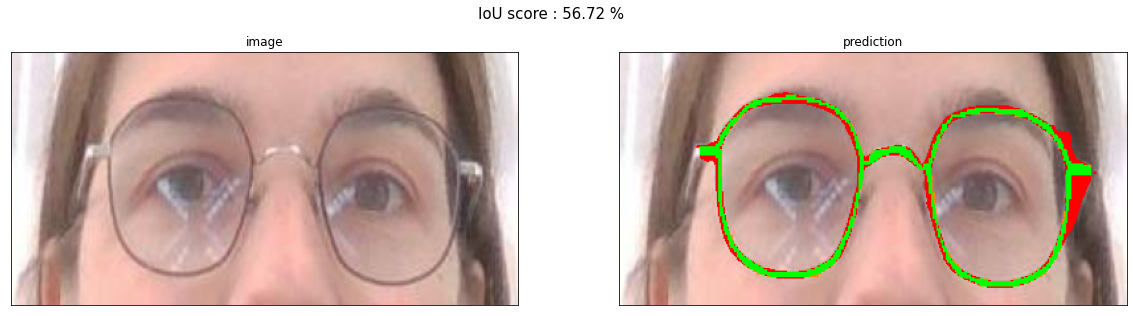

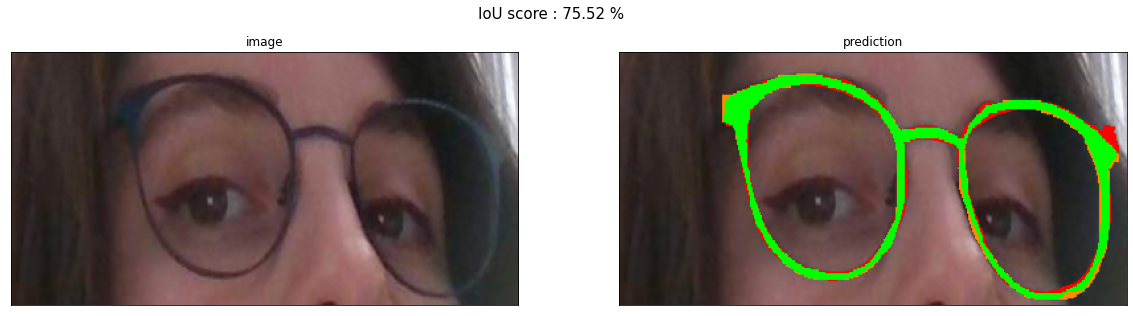

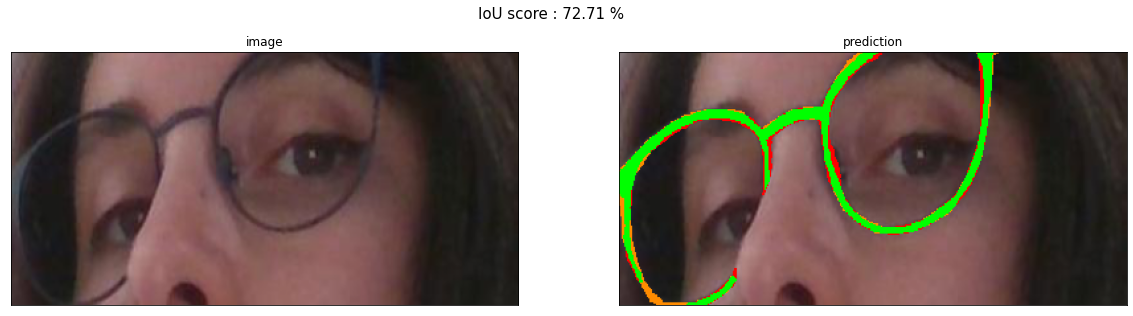

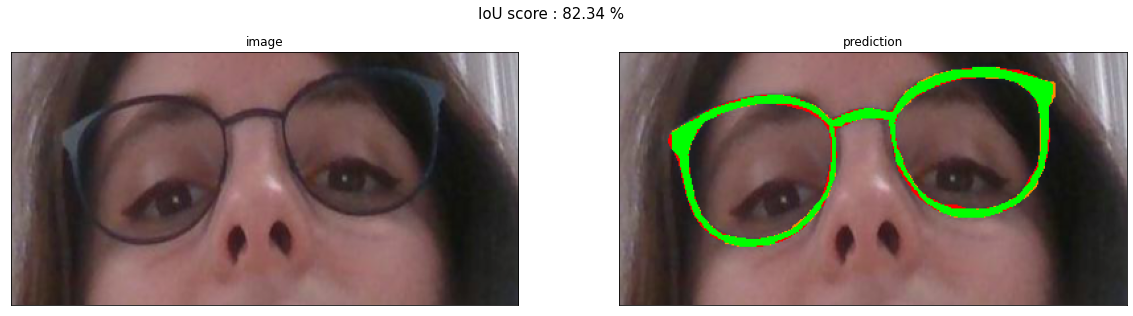

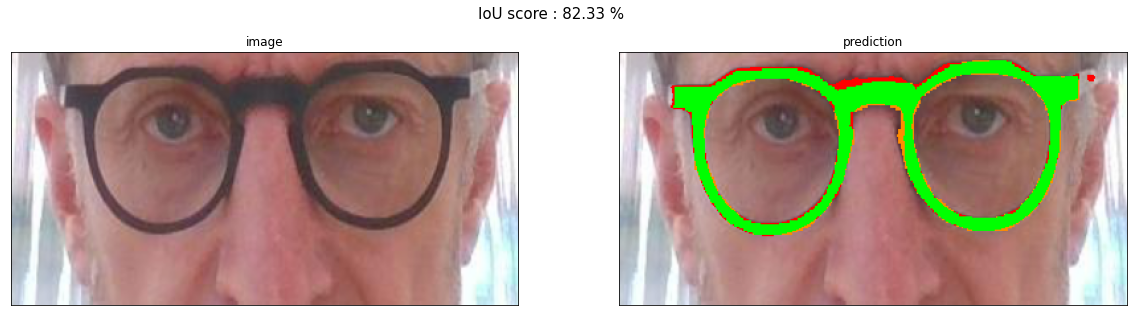

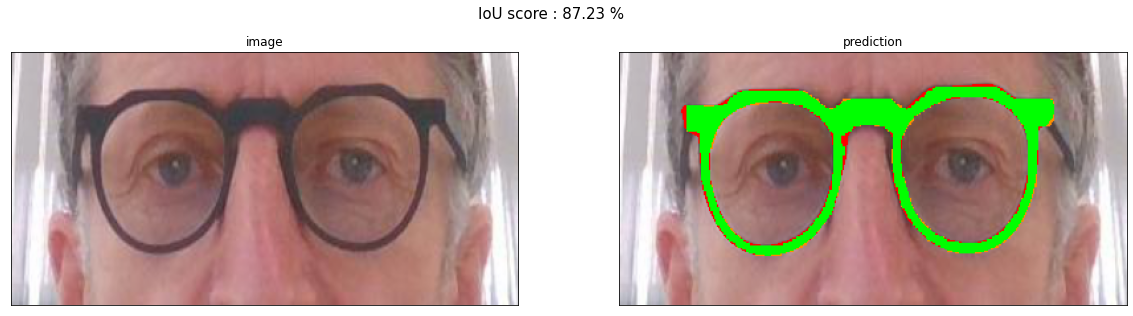

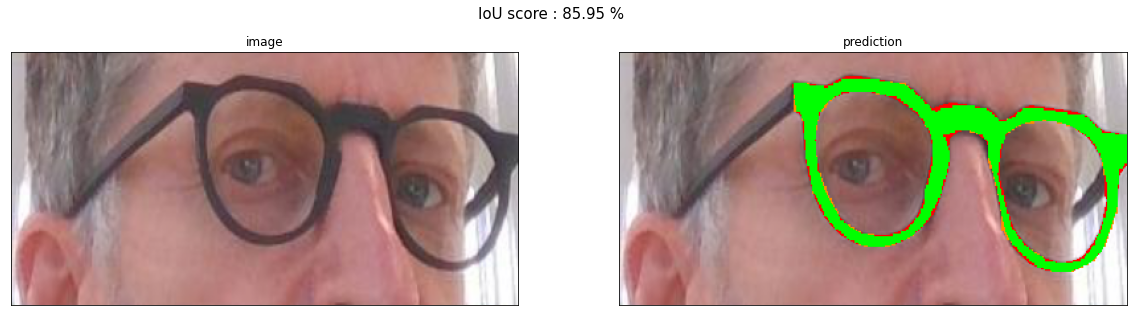

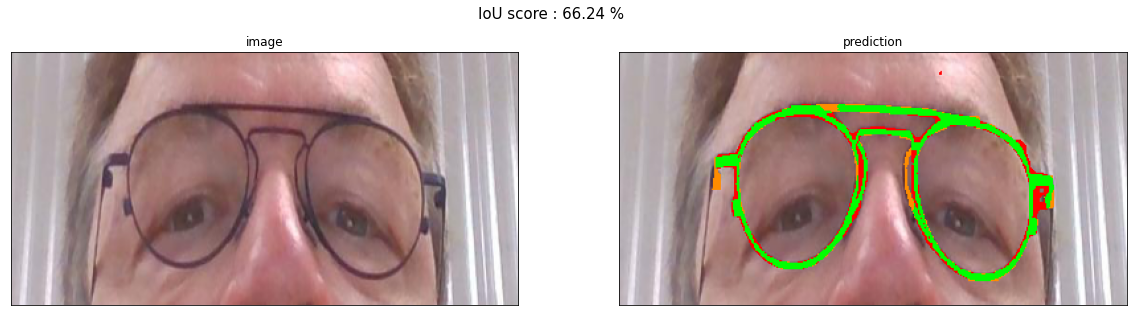

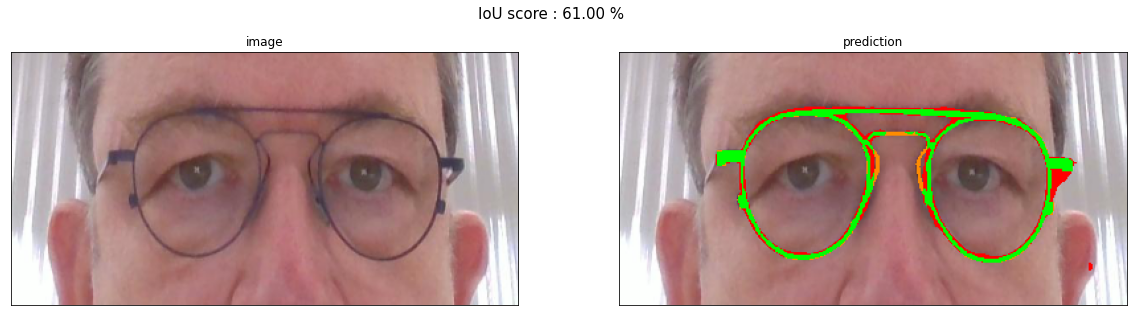

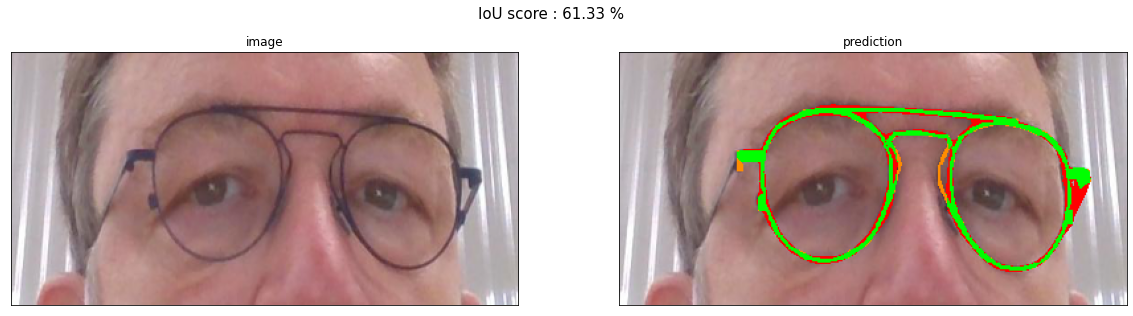

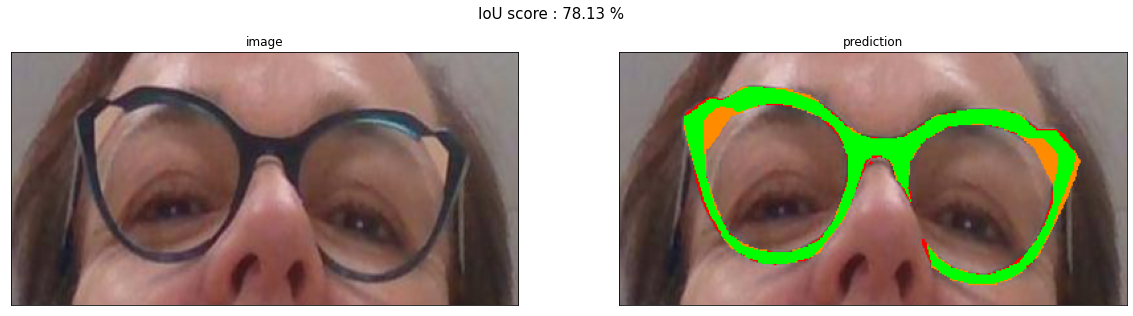

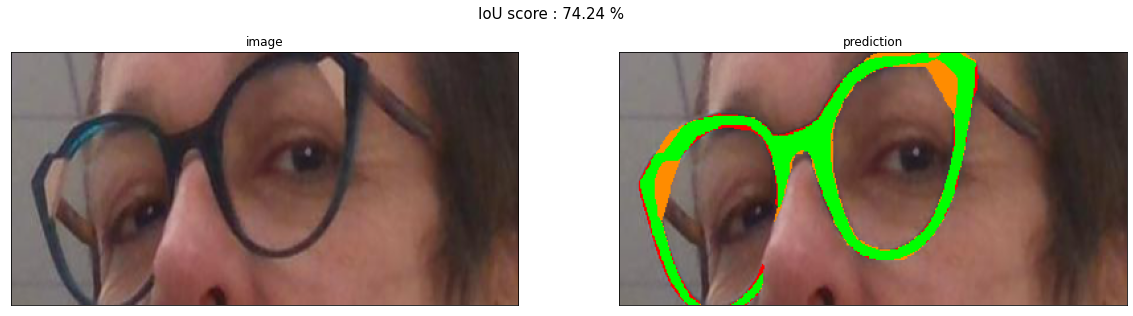

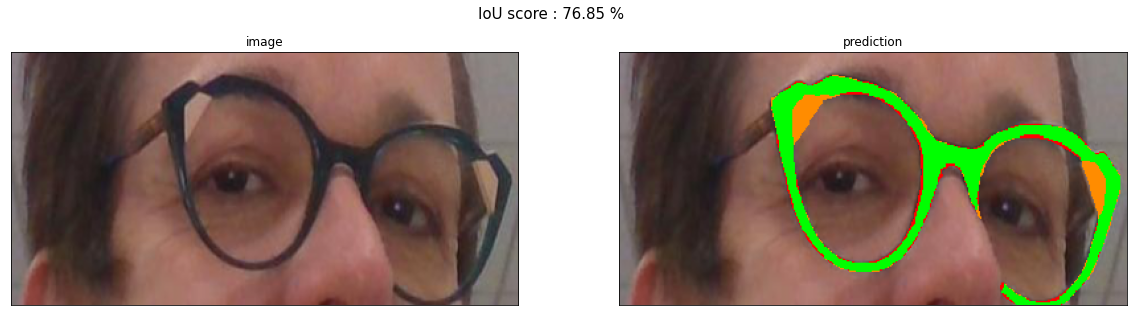

In [13]:
t = []
scores = []
cpt = 25
for image,mask in valid_loader:
    with torch.no_grad():
        start = time.time()
        proba = model.forward(image)
        t.append(time.time()-start)
        score = metric(proba.squeeze(), mask)
        scores.append(score.numpy())
        img = denormalize(image.squeeze(), preprocessing_fn)
        #fig = display_eye_segmentation(img.permute(1,2,0).numpy(), proba.squeeze()>0.5, score='IoU score : {:.2f} %'.format(100*score.numpy()), zoom=False)
        fig, TP, FP, TN, FN = display_result(img.permute(1,2,0).numpy(), mask.squeeze().numpy(), proba.squeeze().numpy()>0.5, score='IoU score : {:.2f} %'.format(100*score.numpy()), zoom=False, legend=False)
        plt.savefig('C:\\Users\\gueganj\\Desktop\\model_crop\\results_using_landmarks\\{:}.jpg'.format(cpt), bbox_inches='tight')
        cpt = cpt + 1

In [71]:
TP, FP, TN, FN

(5143, 822, 67323, 440)

In [72]:
TP/(FP+FN+TP)

0.8029664324746292

In [4]:
sns.displot(data=np.array(scores), kde=True) #, kde_kws={'linewidth': 4,"color":"red"})
plt.xlabel("score",fontsize=13)
plt.title('mean IoU = {:.2f} %'.format(100*sum(scores)/len(scores),fontsize=20))
plt.show()

NameError: name 'np' is not defined

**resize**

In [ ]:
# get original size
mask  = np.array(Image.open(os.path.join(data_root,"masks","frame",image_name+'.png')).convert('P'))
original_size = list(mask.shape[0:2])
original_size[0] -= original_size[0] % 32
original_size[1] -= original_size[1] % 32
input_size = original_size
valid_dataset = Dataset_SMP(image_path, mask_path, input_size, None, get_preprocessing(preprocessing_fn))
valid_loader  = torch.utils.data.DataLoader(valid_dataset)

In [ ]:
image2, mask2 = iter(valid_loader).next()

In [ ]:
with torch.no_grad():
    proba = model.forward(image2)
    score = metric(proba.squeeze(), mask2)

In [ ]:
img2 = denormalize(image2.squeeze(), preprocessing_fn)
fig = display_eye_segmentation(img2.permute(1,2,0).numpy(), proba.squeeze()>0.5, score='IoU score : {:.2f} %'.format(100*score.numpy()), zoom=True)   

In [ ]:
fig, TP, FP, TN, FN = display_result(img2.permute(1,2,0).numpy(), mask2.squeeze().numpy(), proba.squeeze().numpy()>0.5, score='IoU score : {:.2f} %'.format(100*score.numpy()), zoom=True)

In [ ]:
TP, FP, TN, FN

In [ ]:
TP/(FP+FN+TP)

# Test augmentation

Augmenter assez pour s'éloigner de l'image originale et donc que ça fasse effet mais pas trop sinon ça peut avoir l'effet contraire

In [ ]:
import ttach as tta

In [ ]:
transforms = tta.Compose([
        #tta.HorizontalFlip(),
        tta.Scale(scales=[1, 2, 3, 4]), # should preserve the "modulo 32" shape ! 
        # by default in ttach it is a 'nearest' interpolation ! ==> try linear and cubique
        #tta.Multiply(factors=[0.6, 1, 1.4]),        
    ])

tta_model = tta.SegmentationTTAWrapper(model, transforms, merge_mode= "mean")

In [ ]:
data_root  = "C:\\Users\\gueganj\\Desktop\\My_DataBase\\nature\\"
image_name = "045_scanRecord_3"
image_path = [os.path.join(data_root,"images",image_name+'.jpg')]
mask_path  = [os.path.join(data_root,"masks\\frame",image_name+'.png')]
input_size = [352,640]
valid_dataset = Dataset_SMP(image_path, mask_path, input_size, None, get_preprocessing(preprocessing_fn))
valid_loader  = torch.utils.data.DataLoader(valid_dataset)
valid_epoch = smp.utils.train.ValidEpoch(model=tta_model, loss=loss, metrics=[metric], device=device)
logs        = valid_epoch.run(valid_loader)

In [ ]:
# Custom processing
pred_list = []
merger = tta.base.Merger(type="mean", n=len(transforms))
for transformer in transforms:
    # augment image
    augmented_image = transformer.augment_image(image1)
    # pass to model
    with torch.no_grad():
        model_output = model(augmented_image)
    # reverse augmentation for mask and label
    deaug_pred = transformer.deaugment_mask(model_output)
    # save results
    merger.append(deaug_pred)
    pred_list.append(deaug_pred)
    # display
    score = metric(deaug_pred.squeeze(), mask1)
    img = denormalize(augmented_image.squeeze(), preprocessing_fn)
    fig = display_eye_segmentation(img.permute(1,2,0).numpy(), model_output.squeeze()>0.5, score='IoU score : {:.2f} %'.format(100*score.numpy()), zoom=False)
result = merger.result

In [ ]:
img = denormalize(image1.squeeze(), preprocessing_fn)
fig = display_eye_segmentation(img.permute(1,2,0).numpy(), np.abs(pred_list[2]-pred_list[3]).squeeze()>0.5, zoom=True)
plt.title('difference between 2 predictions')
plt.show()